# **Classify covid-19 and normal label from x-ray images**

**Version 1**

* ResNet50 - create bottleneck residual block manually - dont use data augmentation

**Version 2**

* ResNet34 - fine tuning - dont use data augmentation

**Version 3**

* ResNet50 - fine tuning - dont use data augmentation

**Version 4**
* Change patience to 10 in EarlyStoppping


# Version 1 - Build ResNet50 from scratch

# 1.1 Import libs

In [ ]:
# Common lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Utils
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split

# Tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, AveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# 1.2 Exploring data

In [ ]:
input_path = '../input/coronahack-chest-xraydataset'
metadata = pd.read_csv(os.path.join(input_path, 'Chest_xray_Corona_Metadata.csv'), index_col=0)
summary = pd.read_csv(os.path.join(input_path, 'Chest_xray_Corona_dataset_Summary.csv'), index_col=0)

metadata.sample(5)

In [ ]:
# Split to train - test df
train_df = metadata[metadata.Dataset_type == 'TRAIN'].reset_index(drop=True)
test_df = metadata[metadata.Dataset_type == 'TEST'].reset_index(drop=True)
assert train_df.shape[0] + test_df.shape[0] == metadata.shape[0]
print(f'Train df shape: {train_df.shape}')
print(f'Test df shape: {test_df.shape}')

In [ ]:
# Count null values
print(f'Count of null values in train:\n{train_df.isnull().sum()}')
print(f'Count of null values in test:\n{test_df.isnull().sum()}')

In [ ]:
# Fill null value by unknow 
train_df = train_df.fillna('unknow')
test_df = test_df.fillna('unknow')

train_df.sample(5)

In [ ]:
col = ['Label', 'Label_1_Virus_category', 'Label_2_Virus_category']

sns.set_theme(style='darkgrid')
fig = plt.figure(figsize=(14, 14))
for i in range(3):
    ax = plt.subplot(2, 2, i + 1)
    ax = sns.countplot(x=col[i], data=train_df)
    ax.set_title(f'Number of each value in {col[i]} column')
fig.suptitle('Count value in train_df')
plt.show()

In [ ]:
pnemonia_df = train_df[train_df.Label == 'Pnemonia']
print(f'Number of pnemonia in training dataset: { len(pnemonia_df) }')

In [ ]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=col[i+1], data=pnemonia_df)
    ax.set_title(f'Number of each value in {col[i + 1]} column')
fig.suptitle('Count value in pnemonia_df')
plt.show()

In [ ]:
pnemonia_without_unknow_df = pnemonia_df[pnemonia_df.Label_2_Virus_category != 'unknow']
print(f'Number of pnemonia without unknow value in Label_2_Virus_category: { len(pnemonia_without_unknow_df) }')

In [ ]:
fig = plt.figure(figsize=(15, 4))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=col[i+1], data=pnemonia_without_unknow_df)
    ax.set_title(col[i+1])
fig.suptitle('Count value in pnemonia_without_unknow_df')
plt.show()

# 1.3 Prepare data

> We just classify normal case with pnemonia caused by COVID-19 so we will split the dataset with labels normal and COVID-19

In [ ]:
train_folder = os.path.join(input_path, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'train')
test_folder = os.path.join(input_path, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset', 'test')

# Make sure train and test folder existed
assert os.path.isdir(train_folder)
assert os.path.isdir(test_folder)

In [ ]:
# Add column image path to dataframe
train_img_path = pd.Series([os.path.join(train_folder, img_name) for img_name in train_df.X_ray_image_name], name='Image_path')
train_df = pd.concat([train_df, train_img_path], axis=1)

test_img_path = pd.Series([os.path.join(test_folder, img_name) for img_name in test_df.X_ray_image_name], name='Image_path')
test_df = pd.concat([test_df, test_img_path], axis=1)

print(f'Shape of train_df after add column: { train_df.shape }')
print(f'Shape of test_df after add column: { test_df.shape }')

In [ ]:
normal_train_df = train_df[train_df.Label == 'Normal']
# Make sure that normal_train_df doesnt have any virus category
assert len(normal_train_df) == normal_train_df.Label_1_Virus_category.value_counts().unknow
assert len(normal_train_df) == normal_train_df.Label_2_Virus_category.value_counts().unknow
print(f'Shape of normal_train_df: { normal_train_df.shape }')

covid19_train_df = train_df[(train_df.Label == 'Pnemonia') & (train_df.Label_2_Virus_category == 'COVID-19')]
print(f'Shape of covid19_train_df: { covid19_train_df.shape }')

normal_test_df = test_df[test_df.Label == 'Normal']
# Make sure that normal_test_df doesnt have any virus category
assert len(normal_test_df) == normal_test_df.Label_1_Virus_category.value_counts().unknow
assert len(normal_test_df) == normal_test_df.Label_2_Virus_category.value_counts().unknow
print(f'Shape of normal_test_df: { normal_test_df.shape }')

In [ ]:
covid19_test_df = test_df[(test_df.Label == 'Pnemonia') & (test_df.Label_2_Virus_category == 'COVID19')]
print(f'Number of sample in test_df: { len(covid19_test_df) }')

In [ ]:
pnemonia_test_df = test_df[test_df.Label == 'Pnemonia']

fig = plt.figure(figsize=(12, 5))
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=col[i + 1], data=pnemonia_test_df)
    ax.set_title(f'Number of each value in { col[i + 1] } column')
plt.suptitle('Count value in pnemonia_test_df')
plt.show()

`covid19_test_df` doesnt have any `COVID-19` case in `Label_2_Virus_category`. So we handle this problem by move 10 `COVID19` data from `covid19_train_df` to `covid19_test_df` all values in `Label` column by 1

In [ ]:
print(f'Shape of covid19_train_df before split: { covid19_train_df.shape }')
print(f'Shape of covid19_test_df before split: { covid19_test_df.shape }')

In [ ]:
temp = covid19_train_df
covid19_train_df = temp[:48]
covid19_test_df = temp[48:]

print(f'Shape of covid19_train_df after split: { covid19_train_df.shape }')
print(f'Shape of covid19_test_df after split: { covid19_test_df.shape }')

In [ ]:
print(f'Shape of normal_train_df: { normal_train_df.shape }')
print(f'Shape of covid19_train_df: { covid19_train_df.shape }')
print('-------------------------')
print(f'Shape of normal_test_df: { normal_test_df.shape }')
print(f'Shape of covid19_test_df: { covid19_test_df.shape }')

In [ ]:
# Concatenate normal & covid19 df to form train & test dataset
train_df = pd.concat([normal_train_df, covid19_train_df], axis=0).loc[:, ['Image_path', 'Label']]
test_df = pd.concat([normal_test_df, covid19_test_df], axis=0).loc[:, ['Image_path', 'Label']]

# Change to 'negative' & 'positive' label
train_df.Label = train_df.Label.map(lambda label: 'negative' if label == 'Normal' else 'positive')
test_df.Label = test_df.Label.map(lambda label: 'negative' if label == 'Normal' else 'positive')

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Split to validation dataset
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=False)
print('Number of samples in training dataset: ', len(train_df))
print('Number of samples in validation dataset: ', len(valid_df))
print('Number of samples in test dataset: ', len(test_df))

In [ ]:
# Number of each label in dataset
datasets = [train_df, valid_df, test_df]
titles = ['Train set', 'Validation set', 'Test set']
label = ['negative', 'positive']

fig = plt.figure(figsize=(10, 10))
for i in range(3):    
    dataset = datasets[i]
    label_count = dataset.Label.value_counts()
    count = [label_count[0], label_count[1]]
    ax = plt.subplot(2, 2, i+1)
    ax.bar(label, count, color=['b', 'r'])
    ax.set_title('Number of each label in '+ titles[i])
    for index, value in enumerate(count):
        plt.text(index, value, value)
plt.suptitle('Number of each label in dataset')
plt.show()

> From the chart above, we can see this is imbalanced dataset. So we will use AUC as a metric for evaluating our model

# 1.4 Visualize images

In [ ]:
train_df.head()

In [ ]:
# Plot first 6 image in train dataset
fig = plt.figure(figsize=(15,20))
for i in range(6):
    ax = plt.subplot(3, 2, i+1)
    img_path = train_df.Image_path[i]
    label = train_df.Label[i]
    title = 'healthy'
    img = load_img(img_path)
    ax.axis('off')
    ax.set_title(label)
    ax.imshow(img)

plt.tight_layout()

## 1.4.1 Image histogram

> An image histogram is a type of histogram that acts as a graphical representation of the tonal distribution in a digital image. It plots the number of pixels for each tonal value. By looking at the histogram for a specific image a viewer will be able to judge the entire tonal distribution at a glance.

Source: [https://en.wikipedia.org/wiki/Image_histogram](http://)

In [ ]:
# Plot 4 images and image histograms respectively of normal case
first_four_normal_img_name = normal_train_df.X_ray_image_name.iloc[:4]
first_four_normal_img_path = [os.path.join(train_folder, img_name) for img_name in first_four_normal_img_name]

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
for idx, img_path in enumerate(first_four_normal_img_path):
    img = load_img(img_path)
    # Plot image
    ax[idx, 0].imshow(img)
    ax[idx, 0].axis('off')
    # Plot image histogram
    img_arr = img_to_array(img)
    ax[idx, 1].hist(img_arr.ravel(), 256, fc='b', ec='b') # ravel() flatten arr
    if(idx == 0):
        ax[idx, 0].set_title('Image')
        ax[idx, 1].set_title('Image histograms')
fig.suptitle('Normal Case')
plt.show()

In [ ]:
# Plot 3 images and image histograms respectively of COVID19 case
four_covid19_img_name = covid19_train_df.X_ray_image_name.iloc[:4]
four_covid19_img_path = [os.path.join(train_folder, img_name) for img_name in four_covid19_img_name]

fig, ax = plt.subplots(4, 2, figsize=(15, 15))
for idx, img_path in enumerate(four_covid19_img_path):
    # Plot image
    img = load_img(img_path)
    ax[idx, 0].imshow(img)
    ax[idx, 0].axis('off')
    # Plot image histogram
    img_arr = img_to_array(img)
    ax[idx, 1].hist(img_arr.ravel(), 256, fc='b', ec='b')
    if idx == 0:
        ax[idx, 0].set_title('Images')
        ax[idx, 1].set_title('Image histograms')
fig.suptitle('COVID19 Case')
plt.show()

# 1.5 Image data generator (not augmentation)

In [ ]:
train_batches = ImageDataGenerator().flow_from_dataframe(dataframe=train_df,
                                                      x_col='Image_path',
                                                      y_col='Label',
                                                      target_size=(230, 230),
                                                      class_mode='binary',
                                                      batch_size=128,
                                                      shuffle=True)

valid_batches = ImageDataGenerator().flow_from_dataframe(valid_df,
                                                      x_col='Image_path',
                                                      y_col='Label',
                                                      target_size=(230, 230),
                                                      class_mode='binary',
                                                      batch_size=128,
                                                      shuffle=True)

test_batches = ImageDataGenerator().flow_from_dataframe(test_df,
                                                     x_col='Image_path',
                                                     y_col='Label',
                                                     target_size=(230, 230),
                                                     class_mode='binary',
                                                     batch_size=128,
                                                     shuffle=False)

# 1.6 Build model

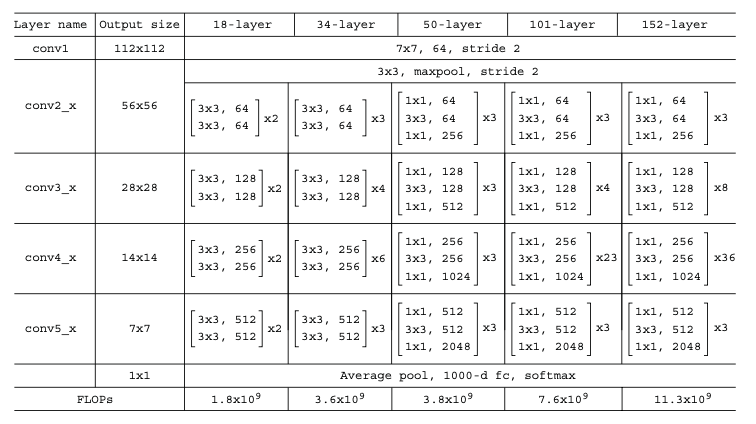

**ResNet architecture**

In [ ]:
# Create function to build 1 block of ResNet
def bottleneck_residual_block(X, kernel_size, filters, reduce=False, strides=1):
    f1, f2, f3 = filters
    X_shortcut = X
    if reduce == True:
        # Reduce shortcut
        X_shortcut = Conv2D(filters=f3, kernel_size=1, strides=strides, padding='valid') (X_shortcut)
        X_shortcut = BatchNormalization() (X_shortcut)
        
    # First component of main path
    X = Conv2D(filters=f1, kernel_size=1, strides=strides, padding='valid') (X)
    X = BatchNormalization() (X)
    X = Activation('relu') (X)
    
    # Second component of main path
    X = Conv2D(filters=f2, kernel_size=kernel_size, strides=1, padding='same') (X)
    X = BatchNormalization() (X)
    X = Activation('relu') (X)
    
    # Third component of main path
    X = Conv2D(filters=f3, kernel_size=1, strides=1, padding='valid') (X)
    X = BatchNormalization() (X)
    
    # Final step
    X = Add() ([X, X_shortcut])
    X = Activation('relu') (X)
    
    return X

In [ ]:
def ResNet50(input_shape):
    X_input = Input(input_shape)
    
    # Stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, padding='valid', name='conv1') (X_input) # Output = (112, 112, 64)
    X = BatchNormalization() (X)
    X = Activation('relu') (X)
    X = MaxPooling2D(pool_size=2, strides=2) (X) # Ouput = (56, 56, 64)
    
    # Stage 2
    X = bottleneck_residual_block(X, 3, (64, 64, 256), True) # Ouput = (56, 56, 256)
    X = bottleneck_residual_block(X, 3, (64, 64, 256)) 
    X = bottleneck_residual_block(X, 3, (64, 64, 256)) 
    
    # Stage 3
    X = bottleneck_residual_block(X, 3, (128, 128, 512), True, 2) # Ouput = (28, 28, 512)
    X = bottleneck_residual_block(X, 3, (128, 128, 512)) 
    X = bottleneck_residual_block(X, 3, (128, 128, 512))
    X = bottleneck_residual_block(X, 3, (128, 128, 512))
    
    # Stage 4
    X = bottleneck_residual_block(X, 3, (256, 256, 1024), True, 2) # Ouput = (14, 14, 1024)
    X = bottleneck_residual_block(X, 3, (256, 256, 1024))
    X = bottleneck_residual_block(X, 3, (256, 256, 1024))
    X = bottleneck_residual_block(X, 3, (256, 256, 1024))
    X = bottleneck_residual_block(X, 3, (256, 256, 1024))
    X = bottleneck_residual_block(X, 3, (256, 256, 1024))
    
    # Stage 5
    X = bottleneck_residual_block(X, 3, (512, 512, 2048), True, 2) # Ouput = (7, 7, 2048)
    X = bottleneck_residual_block(X, 3, (512, 512, 2048))
    X = bottleneck_residual_block(X, 3, (512, 512, 2048))
    
    X = AveragePooling2D(pool_size=7) (X)
    
    X = Flatten() (X)    
    X = Dense(units=1, activation='sigmoid', name='sigmoid') (X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    return model

In [ ]:
if not os.path.exists('models'):
    os.mkdir('models')
if not os.path.exists('models/resnet50'):
    os.mkdir('models/resnet50')

In [ ]:
model_resnet50 = ResNet50((230, 230, 3))

metrics = [TruePositives(name='TP'),
          FalsePositives(name='FP'),
          TrueNegatives(name='TN'),
          FalseNegatives(name='FN'),
          AUC(curve='PR', name='AUC')]

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(0.1),
                             patience=5,
                             min_lr=1e-7,
                             min_delta = 1e-4,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              min_delta=0,
                              verbose=1,
                              restore_best_weights=True)
"""
checkpoint = ModelCheckpoint(filepath='models/resnet50/model-resnet50-{epoch:02d}.hdf5',
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=False)
"""


callbacks = [reduce_lr, early_stopping]

In [ ]:
model_resnet50.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
history_resnet50 = model_resnet50.fit(train_batches, epochs=100, batch_size=128, verbose=1, validation_data=valid_batches,
         callbacks=callbacks)

# 1.7 Evaluate

In [ ]:
history_resnet50_df = pd.DataFrame(history_resnet50.history)

In [ ]:
hist = [history_resnet50.history['AUC'], history_resnet50.history['val_AUC'],
       history_resnet50.history['loss'], history_resnet50.history['val_loss']]
title = ['Training AUC', 'Validation AUC', 'Training loss', 'Validation loss']
ylabel = ['auc value', 'auc value', 'loss value', 'loss value']

fig = plt.figure(figsize=(10, 12))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=np.arange(len(hist[i])), y=hist[i])
    ax.set_title(title[i])
    ax.set_xlabel('epoch')
    ax.set_ylabel(ylabel[i])
plt.show()

In [ ]:
history_resnet50_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [ ]:
history_resnet50_df.loc[:, ['AUC', 'val_AUC']].plot()
plt.show()

In [ ]:
predict_resnet50 = model_resnet50.evaluate(test_batches, verbose=1)

In [ ]:
tp, fp, tn, fn, auc = predict_resnet50[1], predict_resnet50[2], predict_resnet50[3], predict_resnet50[4], predict_resnet50[5]
print(f'True positive: { tp }')
print(f'False positive: { fp }')
print(f'True negative: { tn }')
print(f'False negative: { fn }')
print('AUC: %.2f' % auc)

# Version 2 - Training on ResNet34

# 2.1 Import libs

In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

In [ ]:
from classification_models.tfkeras import Classifiers

# Tensorflow
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 2.2 Data augmentation

In [ ]:
train_batches = ImageDataGenerator().flow_from_dataframe(dataframe=train_df,
                                                      x_col='Image_path',
                                                      y_col='Label',
                                                      target_size=(224, 224),
                                                      class_mode='binary',
                                                      batch_size=128,
                                                      shuffle=True)

valid_batches = ImageDataGenerator().flow_from_dataframe(valid_df,
                                                      x_col='Image_path',
                                                      y_col='Label',
                                                      target_size=(224, 224),
                                                      class_mode='binary',
                                                      batch_size=128,
                                                      shuffle=True)

test_batches = ImageDataGenerator().flow_from_dataframe(test_df,
                                                     x_col='Image_path',
                                                     y_col='Label',
                                                     target_size=(224, 224),
                                                     class_mode='binary',
                                                     batch_size=128,
                                                     shuffle=False)

# 2.3 Fine tuning ResNet34

In [ ]:
ResNet34, preprocess_input = Classifiers.get('resnet34')
base_model = ResNet34((224, 224, 3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D() (base_model.output)
output = Dense(1, activation='sigmoid') (x)
model_resnet34 = Model(inputs=base_model.input, outputs=output)

# 2.4 Train model

In [ ]:
if not os.path.exists('models'):
    os.mkdir('models')
if not os.path.exists('models/resnet34'):
    os.mkdir('models/resnet34')

In [ ]:
metrics = [TruePositives(name='TP'),
          FalsePositives(name='FP'),
          TrueNegatives(name='TN'),
          FalseNegatives(name='FN'),
          AUC(curve='PR', name='AUC')]

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(0.1),
                             patience=5,
                             min_lr=1e-7,
                             min_delta = 1e-4,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              min_delta=0,
                              verbose=1,
                              restore_best_weights=True)

"""
checkpoint = ModelCheckpoint(filepath='models/resnet34/model-resnet34-{epoch:02d}.hdf5',
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=False)
"""


callbacks = [reduce_lr, early_stopping]

In [ ]:
model_resnet34.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=metrics)
history_resnet34 = model_resnet34.fit(train_batches, epochs=100, batch_size=128, verbose=1, validation_data=valid_batches,
         callbacks=callbacks)

# 2.5 Evaluate

In [ ]:
history_resnet34_df = pd.DataFrame(history_resnet34.history)

In [ ]:
history_resnet34_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [ ]:
history_resnet34_df.loc[:, ['AUC', 'val_AUC']].plot()
plt.show()

In [ ]:
hist = [history_resnet34_df['AUC'], history_resnet34_df['val_AUC'],
       history_resnet34_df['loss'], history_resnet34_df['val_loss']]
title = ['Training AUC', 'Validation AUC', 'Training loss', 'Validation loss']
ylabel = ['auc value', 'auc value', 'loss value', 'loss value']

fig = plt.figure(figsize=(10, 12))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=np.arange(len(hist[i])), y=hist[i])
    ax.set_title(title[i])
    ax.set_xlabel('epoch')
    ax.set_ylabel(ylabel[i])
plt.show()

In [ ]:
evaluate_resnet34 = model_resnet34.evaluate(test_batches, verbose=1)

In [ ]:
tp, fp, tn, fn, auc = evaluate_resnet34[1], evaluate_resnet34[2], evaluate_resnet34[3], evaluate_resnet34[4], evaluate_resnet34[5]
print(f'True positive: { tp }')
print(f'False positive: { fp }')
print(f'True negative: { tn }')
print(f'False negative: { fn }')
print('AUC: %.2f' % auc)

# Version 3 - Fine tuning ResNet50

# 3.1 Import libs

In [ ]:
from tensorflow.keras.applications import ResNet50

# 3.2 Build model

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
X = AveragePooling2D(pool_size=7) (base_model.output)
X = Flatten() (X)
X = Dense(1, activation='sigmoid') (X)
fine_tuning_resnet50 = Model(inputs=base_model.input, outputs=X)

# 3.3 Compile model

In [ ]:
metrics = [TruePositives(name='TP'),
          FalsePositives(name='FP'),
          TrueNegatives(name='TN'),
          FalseNegatives(name='FN'),
          AUC(curve='PR', name='AUC')]

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(0.1),
                             patience=5,
                             min_lr=1e-7,
                             min_delta = 1e-4,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              min_delta=0,
                              verbose=1,
                              restore_best_weights=True)


callbacks = [reduce_lr, early_stopping]

In [ ]:
fine_tuning_resnet50.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=metrics)
history_ft_resnet50 = fine_tuning_resnet50.fit(train_batches, epochs=100, batch_size=128, verbose=1, validation_data=valid_batches,
         callbacks=callbacks)

# 3.4 Evaluate model

In [ ]:
history_ft_resnet50_df = pd.DataFrame(history_ft_resnet50.history)

In [ ]:
history_ft_resnet50_df.loc[:, ['loss', 'val_loss']].plot()
plt.show()

In [ ]:
history_ft_resnet50_df.loc[:, ['AUC', 'val_AUC']].plot()
plt.show()

In [ ]:
hist = [history_ft_resnet50_df['AUC'], history_ft_resnet50_df['val_AUC'],
       history_ft_resnet50_df['loss'], history_ft_resnet50_df['val_loss']]
title = ['Training AUC', 'Validation AUC', 'Training loss', 'Validation loss']
ylabel = ['auc value', 'auc value', 'loss value', 'loss value']

fig = plt.figure(figsize=(10, 12))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax = sns.lineplot(x=np.arange(len(hist[i])), y=hist[i])
    ax.set_title(title[i])
    ax.set_xlabel('epoch')
    ax.set_ylabel(ylabel[i])
plt.show()

In [ ]:
evaluate_resnet50 = fine_tuning_resnet50.evaluate(test_batches, verbose=1)

In [ ]:
tp, fp, tn, fn, auc = evaluate_resnet50[1], evaluate_resnet50[2], evaluate_resnet50[3], evaluate_resnet50[4], evaluate_resnet50[5]
print(f'True positive: { tp }')
print(f'False positive: { fp }')
print(f'True negative: { tn }')
print(f'False negative: { fn }')
print('AUC: %.2f' % auc)